In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import importlib
import itertools
import matplotlib.pyplot as plt
from os import path
from keras.callbacks import TensorBoard, ModelCheckpoint
import datetime
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
# Add a directory to the search path
sys.path.append('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI')
from utils.utils import (
    preprocess_traces,
    find_max_trace_length,
    read_segy_file,
    visualize_seismic_data,
    train_contrastive_ts,
    segment_into_sequences,
    create_patches,
    scale_subsequences,
    reshape_into_subsequences,
    generate_test_pairs,
    plot_aline
)
from utils.metrics import (
    pixelwise_accuracy,
    class_accuracy,
    mean_class_accuracy,
    mean_iou,
)
from utils.augmentations import (
    DataAugmentationImage,
    Compose,
    AddNoise,
    RandomCrop,
    CenterCrop,
    RandomHorizontallyFlip,
    RandomVerticallyFlip,
    FreeScale,Scale,
    RandomSizedCrop,
    RandomRotate,
    RandomSized,
    RandomHorizontallyFlip_np,
    RandomVerticallyFlip_np,
    AddNoise_np,
    RandomRotate_np,
)

from geophysics.dhi import DHIComputations
from geophysics.utils import import_and_save_segy,segy_to_npy_prestack, segy_to_npy_with_coordinates, segy_to_npy_with_manual_headers,import_and_save_segy_3d,import_and_save_segy_3d_with_metadata
from utils.utils import read_segy_file
from keras.models import load_model
from utils.debuggers import check_shapes, check_dataset_shapes
from scripts.predict import make_predictions_unet
from utils.visualizations import visualize_original_vs_prediction,reconstruct_from_patches, plot_original_and_reconstructed, plot_sections
from utils.patch import  SeismicProcessor, SeismicProcessor3D, SeismicProcessor1D, SeismicProcessorTests, SeismicProcessorPredict,PatchGeneratorPredict
from data.preprocess import TimeSeriesTFRecordReader,ImageMaskTFRecordWriter,TimeSeriesTFRecordWriter,TFRecordReader,TFRecordWriter
from models.contrastive_learning import ContrastiveTimeSeriesModel, TimeSeriesAugmentation, Contrastive1DCNNModel
from models.contrastive_learning import generate_pairs, contrastive_loss, augment_time_series
from models.CNNs import UNet, ResNetSegmentation, create_segmentation_vgg16_model, unet_model
import numpy as np
import segyio
import tensorflow as tf
import pandas as pd
import keras as ks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'utils.utils'; 'utils' is not a package

In [4]:
# Load training data and labels
# train_seismic = np.load(path.join(config.DATASET.ROOT, "train/train_seismic.npy"))
# train_labels = np.load(path.join(config.DATASET.ROOT, "train/train_labels.npy"))

train_labels = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/train/train_labels.npy')
train_seismic = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/train/train_seismic.npy')

print(f"Number of inline slices: {train_seismic.shape[0]}")
print(f"Number of crossline slices: {train_seismic.shape[1]}")
print(f"Depth dimension : {train_seismic.shape[2]}")

Number of inline slices: 401
Number of crossline slices: 701
Depth dimension : 255


In [100]:
# Printing all available fields in the TraceField enumeration
print(dir(segyio.TraceField))

['AliasFilterFrequency', 'AliasFilterSlope', 'CDP', 'CDP_TRACE', 'CDP_X', 'CDP_Y', 'CROSSLINE_3D', 'CoordinateUnits', 'Correlated', 'DataUse', 'DayOfYear', 'DelayRecordingTime', 'ElevationScalar', 'EnergySourcePoint', 'FieldRecord', 'GainType', 'GapSize', 'GeophoneGroupNumberFirstTraceOrigField', 'GeophoneGroupNumberLastTraceOrigField', 'GeophoneGroupNumberRoll1', 'GroupStaticCorrection', 'GroupUpholeTime', 'GroupWaterDepth', 'GroupX', 'GroupY', 'HighCutFrequency', 'HighCutSlope', 'HourOfDay', 'INLINE_3D', 'InstrumentGainConstant', 'InstrumentInitialGain', 'LagTimeA', 'LagTimeB', 'LowCutFrequency', 'LowCutSlope', 'MinuteOfHour', 'MuteTimeEND', 'MuteTimeStart', 'NStackedTraces', 'NSummedTraces', 'NotchFilterFrequency', 'NotchFilterSlope', 'OverTravel', 'ReceiverDatumElevation', 'ReceiverGroupElevation', 'ScalarTraceHeader', 'SecondOfMinute', 'ShotPoint', 'ShotPointScalar', 'SourceDatumElevation', 'SourceDepth', 'SourceEnergyDirectionExponent', 'SourceEnergyDirectionMantissa', 'SourceGro

In [5]:
test1_labels = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test1_labels.npy')
test1_seismic = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test1_seismic.npy')

test2_labels = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test2_labels.npy')
test2_seismic = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test2_seismic.npy')

print(f"Number of inline slices: {test2_seismic.shape[0]}")
print(f"Number of crossline slices: {test2_seismic.shape[1]}")
print(f"Depth dimension : {test2_seismic.shape[2]}")

Number of inline slices: 601
Number of crossline slices: 200
Depth dimension : 255


In [8]:
# read pre-stack datasets

mobil = read_segy_file('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Mobil_AVO_prestack_seismic.segy')

In [44]:
# read pre-stack datasets
penobscot = read_segy_file('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs.sgy')

In [50]:
penobscot = read_segy_file('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1001.sgy')

In [65]:
import_and_save_segy(
    '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1',
    inline_byte_loc=5, 
    crossline_byte_loc=9, 
    starttime_correction=0
)

Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041.sgy as /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041.npy
Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1561.sgy as /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1561.npy
Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 s

In [66]:
X1041 = np.load( '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041.npy')
X1561 = np.load( '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1561.npy')
X1001 = np.load( '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1001.npy')


In [71]:
import_and_save_segy_3d(
    '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1',
    starttime_correction=0
)

Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041.sgy as /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041_3D.npy
Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1561.sgy as /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1561_3D.npy
Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Deskto

In [72]:
X1041 = np.load( '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041_3D.npy')


In [73]:
X1041.shape

(40, 482, 1501)

In [102]:
import_and_save_segy_3d_with_metadata(
    '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1',
    starttime_correction=0
)

Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041.sgy as /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041_3D.npy and /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1041_offsets.npy
Processed and saved /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Penobscot_3D_gathers_part1/3D_gathers_pstm_nmo_X1561.sgy as /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismi

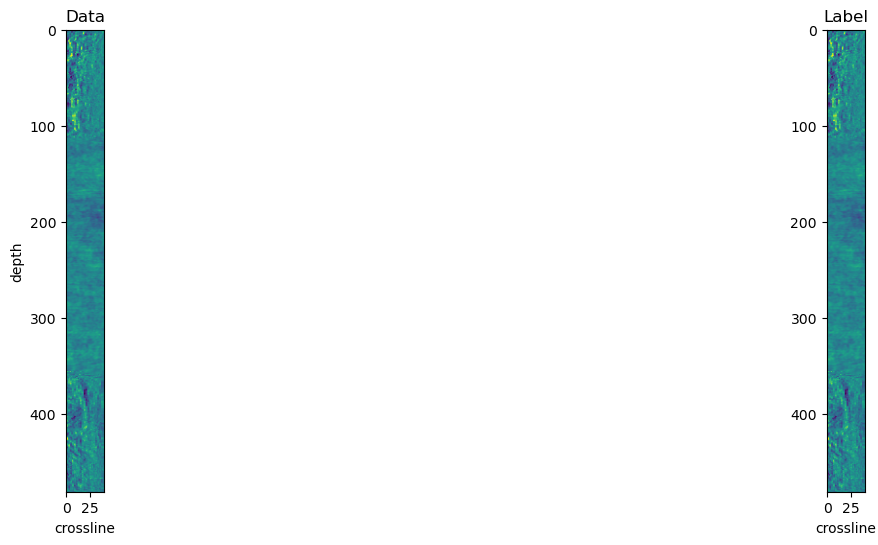

In [88]:
idx = 360
x_cr = X1041[:, :, idx].swapaxes(0, 1)
#x_crl = penobscot[:, :, idx].swapaxes(0, 1)

plot_aline(x_cr,x_cr, xlabel="crossline")

In [10]:
# read post-stack fault datasets
spaveon_fault = read_segy_file('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/Sparveon_blind _detected_fault-002.segy')

In [18]:
segy_file_path = 'path_to_your_segy_file.segy'
npy_file_path = 'path_to_your_output_file.npy'
npy_inline_path = 'path_to_your_output_inline_file.npy'
npy_crossline_path = 'path_to_your_output_crossline_file.npy'
segy_to_npy_with_coordinates(segy_file_path, npy_file_path, npy_inline_path, npy_crossline_path)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:

segy_file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs.sgy'
npy_file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs.npy'
npy_inline_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs_inline.npy'
npy_crossline_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs_crossline.npy'
npy_azimuth_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs_azimuth.npy'
npy_offset_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs_offset.npy'

segy_to_npy_prestack(segy_file_path, npy_file_path, npy_inline_path, npy_crossline_path, npy_azimuth_path, npy_offset_path)

ValueError: Crosslines inconsistent, expect all crosslines to be unique

In [26]:
npy_file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs.npy'
segy_file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs.sgy'

segy_to_npy_with_manual_headers(segy_file_path,npy_file_path)

Data saved to /Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/CrossQI-FinalAngles/CQI-tAngs.npy


In [27]:
penobscot = np.load(npy_file_path)


In [33]:
print(f"Number of inline slices: {penobscot.shape[0]}")
print(f"Number of crossline slices: {penobscot.shape[1]}")
print(f"Depth dimension : {penobscot.shape[2]}")

Number of inline slices: 1598
Number of crossline slices: 1501
Depth dimension : 1479


In [43]:
idx = 50
x_cr = penobscot[:, idx, :].swapaxes(0, 1)
#x_crl = penobscot[:, :, idx].swapaxes(0, 1)

plot_aline(x_cr,x_cr, xlabel="crossline")

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# Example usage
# Assuming 'data' is your loaded 3D seismic dataset:
processor = DHIComputations(train_seismic)

# Compute amplitude and detect bright spots
amplitude = processor.compute_amplitude()
bright_spots = processor.detect_bright_spots(amplitude)

# Compute phase and detect phase reversals
phase = processor.compute_instantaneous_phase()
phase_reversals = processor.detect_phase_reversals(phase)

# Detect other features
flat_spots = processor.detect_flat_spots()
gas_chimneys = processor.detect_gas_chimneys()
shadow_effects = processor.detect_shadow_effects()

In [ ]:
# Calculate thresholds based on the data
thresholds = calculate_thresholds(train_seismic)